# Quick start

...

In [ ]:
# bash generate_data.sh # or use simulate.sh?

In [1]:
import os
import gzip

import numpy as np
import scipy.stats

import skimage.transform
from keras import models, layers, activations, optimizers, regularizers
from keras.utils import to_categorical, plot_model

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pymc3 # this will be removed
import pydot # optional

Using TensorFlow backend.


In [2]:
%run -i ImaGene.py

In [3]:
myfile = ImaFile(simulations_folder='/home/mfumagal/Data/ImaGene/Simulations1.Epoch1', nr_samples=128, model_name='Marth-1epoch-CEU')

In [4]:
mypop = myfile.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=12)

In [5]:
mypop.summary()

An object of 9600 images
Rows: min 128, max 128, mean 128.000000, std 0.000000
Columns: min 53, max 465, mean 319.766250, std 50.490591


0

In [6]:
mypop.majorminor()
mypop.filter_freq(0.01)
mypop.sort('rows_freq')
mypop.sort('cols_freq')
mypop.resize((128, 128))
mypop.convert()
mypop.shuffle()

Converting to numpy array.
Converting to float32.
Converting to [0,1].
Flipping values.
A numpy array with dimensions (9600, 128, 128, 1) and target with length 9600 and 800 classes.


0

In [7]:
import _pickle as pickle

In [ ]:
# to save, create folder
#os.mkdir('/home/mfumagal/Data/ImaGene/Images1.Epoch1')

In [8]:
# save
with open('/home/mfumagal/Data/ImaGene/Images1.Epoch1/mypop_sortedrowscolsfreq','wb') as fp:
    pickle.dump(mypop, fp)

In [33]:
# to load:
with open('/home/mfumagal/Data/ImaGene/Images1.Epoch1/mypop_sortedrowscolsfreq','rb') as fp:
    mypop = pickle.load(fp)

In [22]:
#mypop.majorminor()
#mypop.filter_freq(0.01)
mypop.sort('rows_distance_top')
mypop.sort('cols_distance_top')
mypop.resize((128, 128))
mypop.convert()
mypop.shuffle()

# save
with open('/home/mfumagal/Data/ImaGene/Images1.Epoch1/mypop_sortedrowscolsdist','wb') as fp:
    pickle.dump(mypop, fp)
    
# to load:
with open('/home/mfumagal/Data/ImaGene/Images1.Epoch1/mypop_sortedrowscolsdist','rb') as fp:
    mypop = pickle.load(fp)

Converting to [0,1].
Flipping values.
A numpy array with dimensions (9600, 128, 128, 1) and target with length 9600 and 800 classes.


In [31]:
# to load:
with open('/home/mfumagal/Data/ImaGene/Images1.Epoch1/mypop_sortedrowscolsdist','rb') as fp:
    mypop = pickle.load(fp)

0


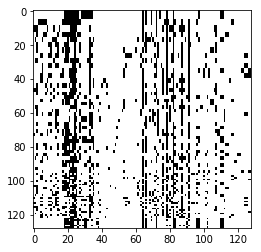

100


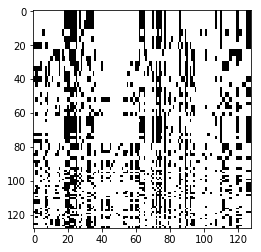

200


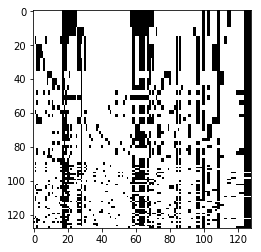

300


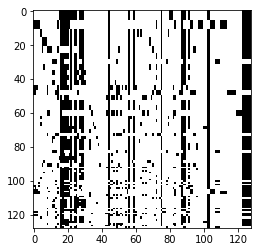

400


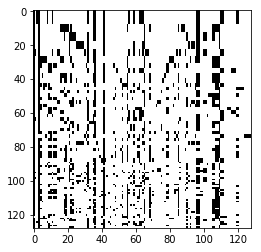

500


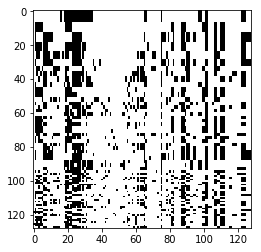

600


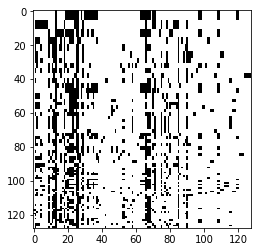

700


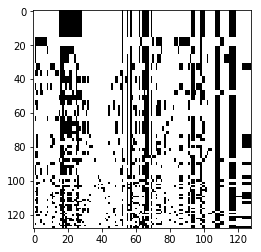

799


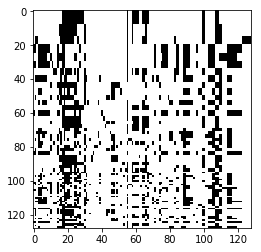

In [34]:
for sel in [0,100,200,300,400,500,600,700,799]:
    ind=np.where(mypop.target == sel)[0][2]
    print(sel)
    mypop.plot(ind)

589


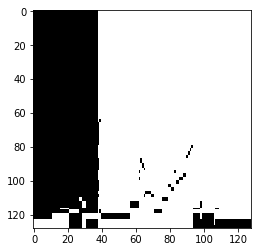

0

In [25]:
ind=np.where(mypop.target == 399)[0][0]
print(ind)
mypop.plot(ind)

In [35]:
mypop.set_classes(nr_classes=5)
mypop.classes

array([  0.  , 199.75, 399.5 , 599.25, 799.  ])

In [36]:
mypop.set_targets(sd=0, wiggle=0)
mypop.target

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [41]:
mynet = ImaNet(mypop)

In [42]:
model = models.Sequential([
                        layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same", input_shape=mynet.input_shape),
                        layers.MaxPooling2D(pool_size=(2,2)),
                        layers.Dropout(rate=0.5),
                        layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same", input_shape=mynet.input_shape),
                        layers.MaxPooling2D(pool_size=(2,2)),
                        layers.Dropout(rate=0.5),
                        layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same", input_shape=mynet.input_shape),
                        layers.MaxPooling2D(pool_size=(2,2)),
                        layers.Dropout(rate=0.5),
                        layers.Flatten(),
                        #layers.Dense(units=128, activation="relu"),
                        layers.Dense(units=mynet.output_shape, activation="softmax")])

model.compile(optimizer=optimizers.Adam(0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [43]:
mynet.net = model
#mynet.plot_net()

In [ ]:
mynet.train(epochs=50, batch_size=64)

Train on 6144 samples, validate on 1536 samples
Epoch 1/50
6144/6144 [==============================] - 26s 4ms/step - loss: 1.5781 - acc: 0.2445 - val_loss: 1.5877 - val_acc: 0.2409
Epoch 2/50
6144/6144 [==============================] - 27s 4ms/step - loss: 1.5624 - acc: 0.2432 - val_loss: 1.5892 - val_acc: 0.2467
Epoch 3/50
6144/6144 [==============================] - 26s 4ms/step - loss: 1.5627 - acc: 0.2614 - val_loss: 1.5753 - val_acc: 0.2467
Epoch 4/50
6144/6144 [==============================] - 27s 4ms/step - loss: 1.5610 - acc: 0.2572 - val_loss: 1.5753 - val_acc: 0.2552
Epoch 5/50
6144/6144 [==============================] - 27s 4ms/step - loss: 1.5604 - acc: 0.2599 - val_loss: 1.5716 - val_acc: 0.2507
Epoch 6/50
6144/6144 [==============================] - 26s 4ms/step - loss: 1.5567 - acc: 0.2653 - val_loss: 1.5799 - val_acc: 0.2585
Epoch 7/50
6144/6144 [==============================] - 27s 4ms/step - loss: 1.5580 - acc: 0.2612 - val_loss: 1.5719 - val_acc: 0.2578
Epoch 8

In [ ]:
mynet.plot_train()

In [ ]:
mynet.test()

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
pred = np.argmax(mynet.net.predict(mynet.gene.data, batch_size=None), axis=1)
true = np.argmax(mynet.gene.target, axis=1)

In [ ]:
reg = LinearRegression().fit(true.reshape(-1,1), pred.reshape(-1,1))

In [ ]:
plt.scatter(true, pred , marker='o')
plt.title('Linear relationship between true and predicted labels')
plt.xlabel('True label')
plt.ylabel('Predicted label')